In [10]:
# !pip install pandas==1.5.3

import warnings
import sys, os, cv2, glob, json, gc, shutil
import multiprocessing
from multiprocessing import Pool

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from moviepy.editor import VideoFileClip
import skvideo.io

import pandas as pd
import numpy as np
import circstat as CS
import scipy as sc
import math, random

import itertools
from itertools import chain
from tqdm import tqdm


from processing import *
from kinematics import *
from skeleton import *

warnings.filterwarnings("ignore")

os.makedirs('./data',exist_ok=True)
os.makedirs('./utils',exist_ok=True)


DEIDENTIFY = True #set to True to deidentify data, and exclude xy coordinates and pixel values from output
OVERWRITE = True
USE_CENTER_INSTANCE = False
USE_BEST_INSTANCE = True

dataset = 'Youtube'
algorithm = 'pvtv2'

json_path = f'./data/Infant Pose Data/{dataset}/{algorithm}/annotations'
json_files = os.listdir(json_path)
json_files = [f for f in json_files if f.endswith('.json')]
directory = f'./data'

save_path = f'./pose_estimates/{dataset}_{algorithm}_pose_estimates'

os.makedirs(save_path, exist_ok=True)

kp_mapping = {0:'Nose', 1:'Neck', 2:'RShoulder', 3:'RElbow', 4:'RWrist', 5:'LShoulder', 6:'LElbow',
              7:'LWrist', 8:'RHip', 9:'RKnee', 10:'RAnkle', 11:'LHip',
              12:'LKnee', 13:'LAnkle', 14:'REye', 15:'LEye', 16:'REar', 17:'LEar'}

limbs_by_name = {
    'Shoulder Width': ['RShoulder', 'LShoulder'],
    'R upper arm': ['RShoulder', 'RElbow'],
    'L upper arm': ['LShoulder', 'LElbow'],
    'R lower arm': ['RElbow', 'RWrist'],
    'L lower arm': ['LElbow', 'LWrist'],
    'Hip Width': ['RHip', 'LHip'],
    'R thigh': ['RHip', 'RKnee'],
    'L thigh': ['LHip', 'LKnee'],
    'R calf': ['RKnee', 'RAnkle'],
    'L calf': ['LKnee', 'LAnkle'],
    'R torso': ['RShoulder', 'RHip'],
    'L torso': ['LShoulder', 'LHip'],
}

# Define the DataFrame columns as specified
columns = ['video_number', 'video', 'bp', 'frame', 'x', 'y', 'c','fps', 'pixel_x', 'pixel_y', 'time', 'part_idx']
data = []  # This will hold the data to be loaded into the DataFrame

vid_info = pd.read_csv(f'./data/{dataset}_video_info.csv')

# Smooth detections and compute features
pose_estimate_path = f'./pose_estimates/{dataset}_pose_estimates/{algorithm}'
# pose_estimate_path = f'./pose_estimates/Wenrui'
csv_path = f'{pose_estimate_path}/pose_estimates_{dataset}.csv'
save_path = f'{pose_estimate_path}/pose_estimates_{dataset}_processed.csv'

# List of subdirectories to create
subdirs = [
    "smooth",
    "raw",
    "anim"
]

# Create necessary directories
for subdir in subdirs:
     os.makedirs(f'{pose_estimate_path}/{subdir}', exist_ok=True)

print(pose_estimate_path)
print(vid_info.head())


./pose_estimates/Youtube_pose_estimates/pvtv2
          video    fps  width  height
0  video_000000  29.97   1280     720
1  video_000001  29.97   1280     720
2  video_000004  29.97    640     360
3  video_000005  30.00    480     360
4  video_000011  30.00    480     360


In [107]:
# format files as pkl with openpose standard and bodypart labels

def process_file(args):
    """Function to process a single file."""
    file_number, file, json_path, save_path, vid_info, kp_mapping = args
    # Construct the full file path
    file_path = os.path.join(json_path, file)
    fname = file.split('.')[0]
    interim = []


    # if not OVERWRITE and os.path.exists(f'{save_path}/{fname}.csv'):
    #     return

    # Open and load the JSON data
    try: 
        with open(file_path, 'r') as f:
            frames = json.load(f)
            info = vid_info[vid_info['video'] == fname]

            fps = info['fps'].values[0]

            pixel_x = info['width'].values[0]
            pixel_y = info['height'].values[0]
            
            center_x = pixel_x / 2
            center_y = pixel_y / 2

            # print(f'Processing {file_path}')
            # Iterate through each frame in the JSON file
            for frame in frames:
                frame_id = frame['frame_id']

                if 'instances' in frame and len(frame['instances']) > 0:

                    if USE_CENTER_INSTANCE:
                        instance_id = get_center_instance(frame['instances'], center_x, center_y)
                    elif USE_BEST_INSTANCE:
                        instance_id = get_best_instance(frame['instances'])
                    else:
                        instance_id = 0

                    keypoints = frame['instances'][instance_id]['keypoints']
                    confidence = frame['instances'][instance_id]['keypoint_scores']
                    keypoints, confidence = convert_coco_to_openpose(keypoints, confidence)

                    # Iterate through each keypoint
                    for part_idx, (x, y) in enumerate(keypoints):

                        bp = kp_mapping[part_idx]
                        fps = fps
                        time = frame_id / fps
                        c = confidence[part_idx]

                        row = [file_number, fname, bp, frame_id, x, y, c, fps, pixel_x, pixel_y, time, part_idx]
                        
                        interim.append(row)
                else:
                    print(f'No instances found in frame {frame_id} of {file_path}')
                    continue

        interim_df = pd.DataFrame(interim, columns=columns)
        interim_df.to_csv(f'{pose_estimate_path}/{fname}.csv', index=False)
        # print(f'{pose_estimate_path}/{fname}.csv')
        # interim_df.to_pickle(f'{save_path}/{fname}.pkl')

        del interim_df
        return
    
    except Exception as e:
        print(f'Error processing {file_path}: {e}')
        print(info)

        return
    
def process_annotations_multiprocess(json_files, json_path, save_path, vid_info, kp_mapping):
    """Run the annotation processing using multiprocessing."""
    args = [
        (file_number, file, json_path, save_path, vid_info, kp_mapping)        

        for file_number, file in enumerate(json_files)
    ]

    # Set up a pool of workers
    with Pool(processes=20) as pool:
        pool.map(process_file, args)


In [108]:
process_annotations_multiprocess(json_files, json_path, save_path, vid_info, kp_mapping)

In [109]:
def process_dataframe(file):
    df = pd.read_csv(os.path.join(pose_estimate_path, file))

    if df.empty:
        print("DataFrame is empty, skipping processing.")
        return
    print(f"Processing DataFrame for video_number: {df['video_number'].iloc[0]}")
    try:
        if dataset == 'Youtube':
            session = df['video'].unique()[0].split('_')[1][0]
            infant = df['video'].unique()[0].split('_')[1][3:]
            age = '3Month'
        elif dataset == 'Clinical':
            # split based on naming convention
            session = df['video'].unique()[0].split('_')[1][1]
            infant = df['video'].unique()[0].split('_')[0][-1]
            age = '3Month'
        elif dataset == 'gma_score_prediction': 
            session = 0
            infant = df['video'].unique()[0]
            age = '3Month'
        elif dataset == 'CHOP': 
            session = df['video'].unique()[0].split('_')[1]
            infant = df['video'].unique()[0].split('_')[0]
            age = df['video'].unique()[0].split('_')[2]
        elif "AIM" or "3D" in dataset:
            parts = df['video'].unique()[0].split('_')
            session = '_'.join(parts[1:4])  # Join parts to form the date string     
            infant = df['video'].unique()[0].split('_')[5]
            age = 'NaN'
        
            # print(f'infant: {infant} {session} {age}')

        median_window = 1
        mean_window = 1
        delta_window = 0.25  # Smoothing applied to delta_x, velocity, acceleration

        df['x'] = pd.to_numeric(df['x'])
        df['y'] = pd.to_numeric(df['y'])

        #filter low confidence detections
        #df = df[df['c'] > 0.5]

        df_no_smooth_no_norm = df.copy()
        df_no_smooth_no_norm = dont_normalise_skeletons(df_no_smooth_no_norm)
        df_no_smooth_no_norm.to_csv(f'{pose_estimate_path}/raw/{infant}_{session}_{age}.csv')    
        # Interpolate
        df = df.groupby(['video', 'bp']).apply(interpolate_df).reset_index(drop=True)

        # Median and mean filter
        median_window = 0.5
        mean_window = 0.5
        df = df.groupby(['video', 'bp']).apply(lambda x: smooth(x, 'y', median_window, mean_window)).reset_index(drop=True)
        df = df.groupby(['video', 'bp']).apply(lambda x: smooth(x, 'x', median_window, mean_window)).reset_index(drop=True)
        
        df = dont_normalise_skeletons(df)
        #df = normalise_skeletons(df) 
        name = df['video'].unique()[0]
        
        # remove the r_ prefix from the video name
        if name.startswith('r_'):
            name = name[2:]
        
        df.to_csv(f'{pose_estimate_path}/smooth/{infant}_{session}_{age}_smooth_nonorm.csv')
        #df.to_csv(f'{pose_estimate_path}/smooth/{infant}_{session}_{age}_smooth_norm.csv')
        # df.to_pickle(f'{pose_estimate_path}/pkl/{name}.pkl')
        
    except:
        f'could not process video {df["video"].unique()[0]}'
        return


In [110]:
pose_estimate_files = os.listdir(pose_estimate_path)
pose_estimate_files = [file for file in pose_estimate_files if file.endswith('.csv')]

# pose_estimate_files = random.sample(pose_estimate_files, 10)

print(f'Processing {len(pose_estimate_files)} files')

Processing 94 files


In [111]:
with Pool(processes=2) as pool:
    pool.map(process_dataframe, pose_estimate_files)

Processing DataFrame for video_number: 38
Processing DataFrame for video_number: 6
Processing DataFrame for video_number: 14
Processing DataFrame for video_number: 26
Processing DataFrame for video_number: 2
Processing DataFrame for video_number: 5
Processing DataFrame for video_number: 30
Processing DataFrame for video_number: 18
Processing DataFrame for video_number: 28
Processing DataFrame for video_number: 4
Processing DataFrame for video_number: 12
Processing DataFrame for video_number: 32
Processing DataFrame for video_number: 24
Processing DataFrame for video_number: 34
Processing DataFrame for video_number: 10
Processing DataFrame for video_number: 35
Processing DataFrame for video_number: 16
Processing DataFrame for video_number: 8
Processing DataFrame for video_number: 20
Processing DataFrame for video_number: 0
Processing DataFrame for video_number: 39
Processing DataFrame for video_number: 15
Processing DataFrame for video_number: 36
Processing DataFrame for video_number: 2

In [ ]:
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0],
          [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255],
          [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85],[255, 0, 0]]

limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
           [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
           [1, 16], [16, 18]] #[3, 17], [6, 18]]

def plot_skel(df, ax, xvar, yvar):
    alpha = 0.3

    for i, limb in enumerate(limbSeq):
        l1 = limb[0] - 1
        l2 = limb[1] - 1
        df_l1 = df[df.part_idx == l1]
        df_l2 = df[df.part_idx == l2]
        if not df_l1.empty and not df_l2.empty:
            ax.plot(
                [df_l1[xvar].iloc[0], df_l2[xvar].iloc[0]],
                [df_l1[yvar].iloc[0], df_l2[yvar].iloc[0]],
                linewidth=5,
                color=[j / 255 for j in colors[i]],
                alpha=alpha,
            )

    for i in range(len(df)):
        ax.plot(
            df.iloc[i][xvar],
            df.iloc[i][yvar],
            'o',
            markersize=10,
            color=[j / 255 for j in colors[i]],
            alpha=alpha,
        )


def animate_coordinates_with_skeleton(file):
    
    file = f'{pose_estimate_path}/smooth/{file}'
    df = pd.read_csv(file)

    fname = os.path.basename(file)

    fps = df.fps[0]
    framen = df.frame.max()
    frame_interval = 5
    dpi = 80

    output_gif = f'{pose_estimate_path}/anim/{os.path.splitext(fname)[0]}.gif'
    print(output_gif)

    fig, ax = plt.subplots(figsize=(6, 6), dpi=dpi)
    ax.set_aspect('equal', adjustable='box')
    # ax.set_xlim(-3, 3)
    # ax.set_ylim(-3, 3)
    ax.invert_yaxis()
    ax.axis('off')

    def update(frame_idx):
        ax.clear()
        ax.set_aspect('equal', adjustable='box')
        # ax.set_xlim(-3, 3)
        # ax.set_ylim(-3, 3)
        ax.invert_yaxis()
        ax.axis('off')
        plot_skel(df[df.frame == frame_idx], ax, 'x', 'y')

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=range(0, framen, frame_interval),
        interval=int(1 / fps * 1000 * frame_interval),
        repeat_delay=1000
    )

    ani.save(output_gif, dpi=dpi)
    plt.close(fig)

    del ani, df, fig, ax
    gc.collect()


In [ ]:
smooth_files = os.listdir(f'{pose_estimate_path}/smooth')
#smooth_files = os.listdir(f'{pose_estimate_path}')
smooth_files = [file for file in smooth_files if file.endswith('.csv')]

output_names = os.listdir(f'{pose_estimate_path}/anim')
output_names = [file for file in output_names if file.endswith('.gif')]

match = []
for name in output_names:
    parts = name.split('.')[0]
    match.append(f'{parts}.csv')

# smooth_files = [file for file in smooth_files if file not in match]
#smooth_files = random.sample(smooth_files, 5)

print(len(smooth_files))


94


In [15]:
with Pool(processes=5) as pool:
    pool.map(animate_coordinates_with_skeleton, smooth_files)

FileNotFoundError: [Errno 2] No such file or directory: './pose_estimates/Youtube_pose_estimates/alexnet/smooth/video_000398.csv'

In [112]:
smooth_files = os.listdir(f'{pose_estimate_path}/smooth')
smooth_files = [file for file in smooth_files if file.endswith('.csv')]

raw_files = os.listdir(f'{pose_estimate_path}/raw')
raw_files = [file for file in raw_files if file.endswith('.csv')]

print(len(smooth_files), len(raw_files))    

94 94


In [8]:
all_algos = ['alexnet','hrnet','hrnet_albu', 'pvtv2', 'vitposes','vitposeh']

In [ ]:

compare_df = pd.DataFrame(columns=['video', 'algo', 'bp', 'frame', 'x', 'y', 'c','fps', 'pixel_x', 'pixel_y', 'time', 'part_idx'])

for algo in all_algos:
    for file in os.listdir(f'./pose_estimates/{dataset}_pose_estimates/{algo}/raw'):
        df = pd.read_csv(f'./pose_estimates/{dataset}_pose_estimates/{algo}/raw/{file}')
        df['algo'] = algo
        compare_df = pd.concat([compare_df, df])


In [119]:
compare_df.to_csv(f'algorithm_comparison.csv', index=False)

In [3]:
compare_df = pd.read_csv(f'algorithm_comparison.csv')

In [4]:
# get keypoint confidence (c) per algorithm across all videos, frames, and bodyparts
mean_confidence_by_algo = compare_df.groupby(['bp', 'algo'])['c'].mean().reset_index()

mean_confidence_by_algo.head()

,bp,algo,c
0,LAnkle,alexnet,0.303862
1,LAnkle,hrnet,0.773570
2,LAnkle,hrnet_albu,0.741740
3,LAnkle,pvtv2,0.768382
4,LAnkle,vitposeh,0.885880


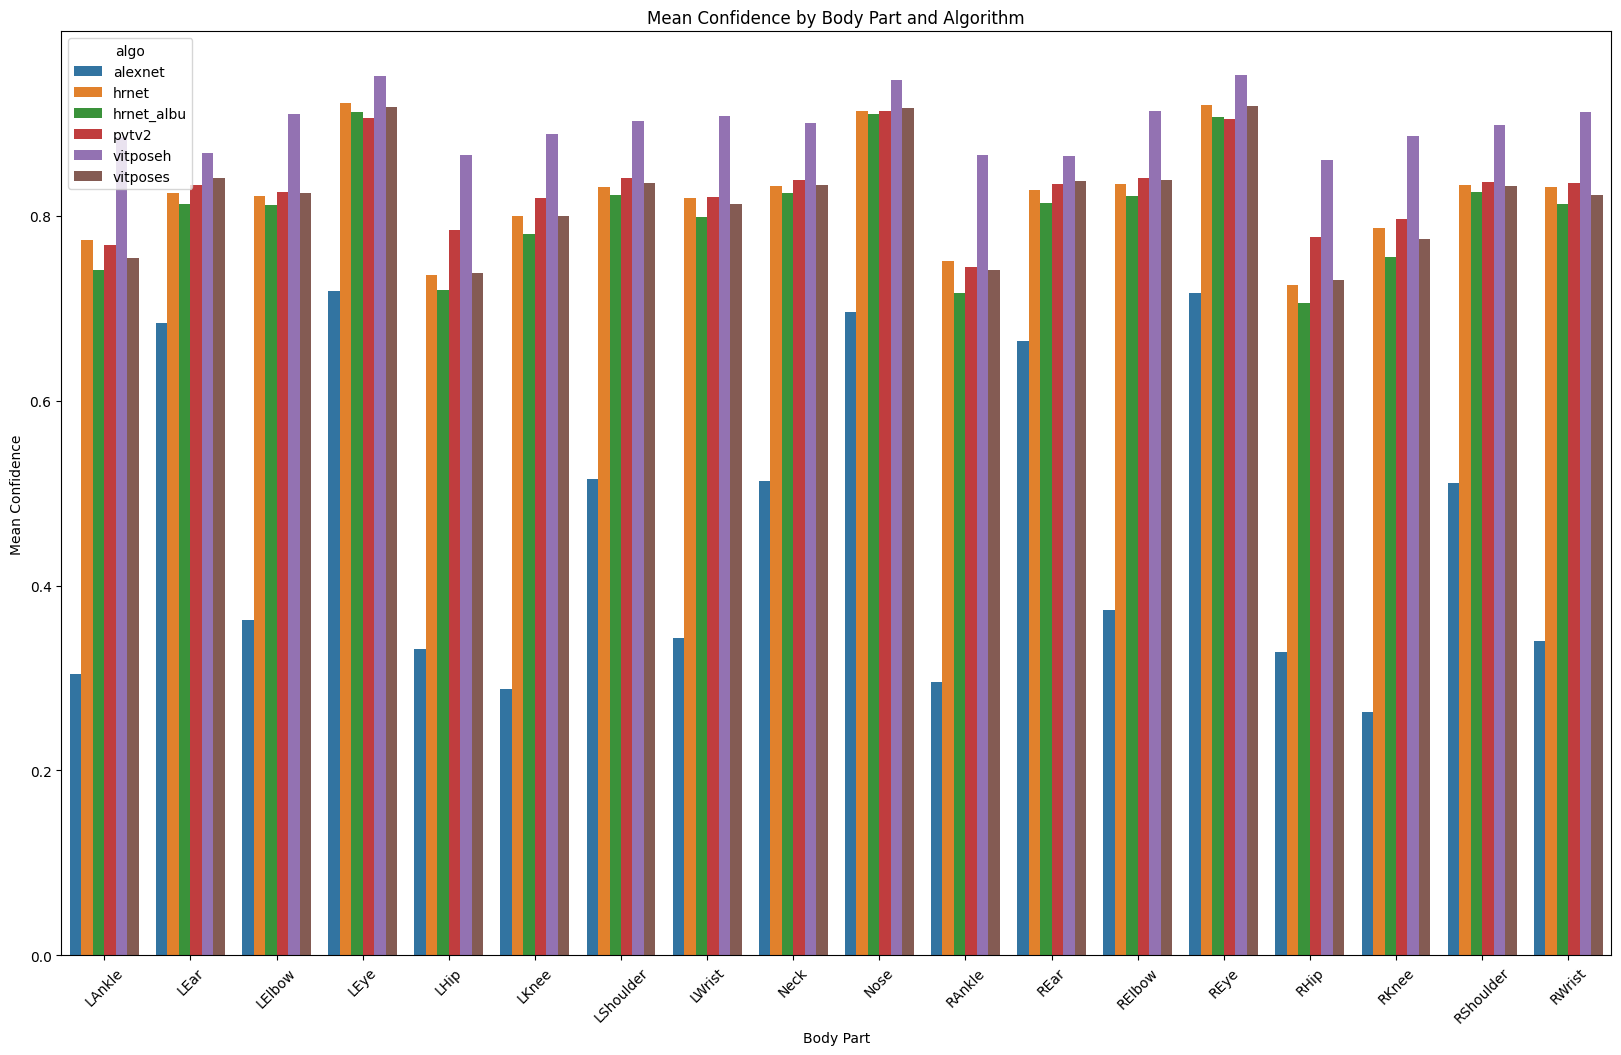

In [120]:
#plot the confidence by body part and algorithm
import seaborn as sns
plt.figure(figsize=(20, 12))

sns.barplot(x='bp', y='c', hue='algo', data=mean_confidence_by_algo)
plt.title('Mean Confidence by Body Part and Algorithm')
plt.ylabel('Mean Confidence')
plt.xlabel('Body Part')
plt.xticks(rotation=45)
plt.show()

In [5]:
# select the slice of combined df that has bp in key_parts
key_parts = ['ankle', 'knee', 'wrist', 'elbow', 'shoulder', 'hip']

test = compare_df[compare_df['bp'].str.lower().str.contains('|'.join(key_parts))]
test['side'] = test['bp'].apply(lambda x: 'L' if x[0] == 'L' else ('R' if x[0] == 'R' else 'N'))
test['part'] = test['bp'].apply(lambda x: x[1:] if x[0] == 'L' or x[0] == 'R' else x)

test.head()

,video,algo,bp,frame,x,y,c,fps,pixel_x,pixel_y,...,lrefx,refx,refy,ref_dist,ref_angle,x_rotate,y_rotate,delta_t,side,part
2,video_000269,alexnet,RShoulder,0,90.626968,160.619049,0.566304,28.621,272,480,...,133.731689,139.119774,163.184807,174.554667,6.230325,-0.278197,0.000000,0.034939,R,Shoulder
3,video_000269,alexnet,RElbow,0,47.522243,247.854797,0.485013,28.621,272,480,...,133.731689,139.119774,163.184807,174.554667,6.230325,-0.498388,0.512111,0.034939,R,Elbow
4,video_000269,alexnet,RWrist,0,9.805616,314.564453,0.330546,28.621,272,480,...,133.731689,139.119774,163.184807,174.554667,6.230325,-0.693967,0.905164,0.034939,R,Wrist
5,video_000269,alexnet,LShoulder,0,187.612579,165.750565,0.392626,28.621,272,480,...,133.731689,139.119774,163.184807,174.554667,6.230325,0.278197,0.000000,0.034939,L,Shoulder
6,video_000269,alexnet,LElbow,0,263.045837,222.197220,0.561211,28.621,272,480,...,133.731689,139.119774,163.184807,174.554667,6.230325,0.726826,0.300091,0.034939,L,Elbow


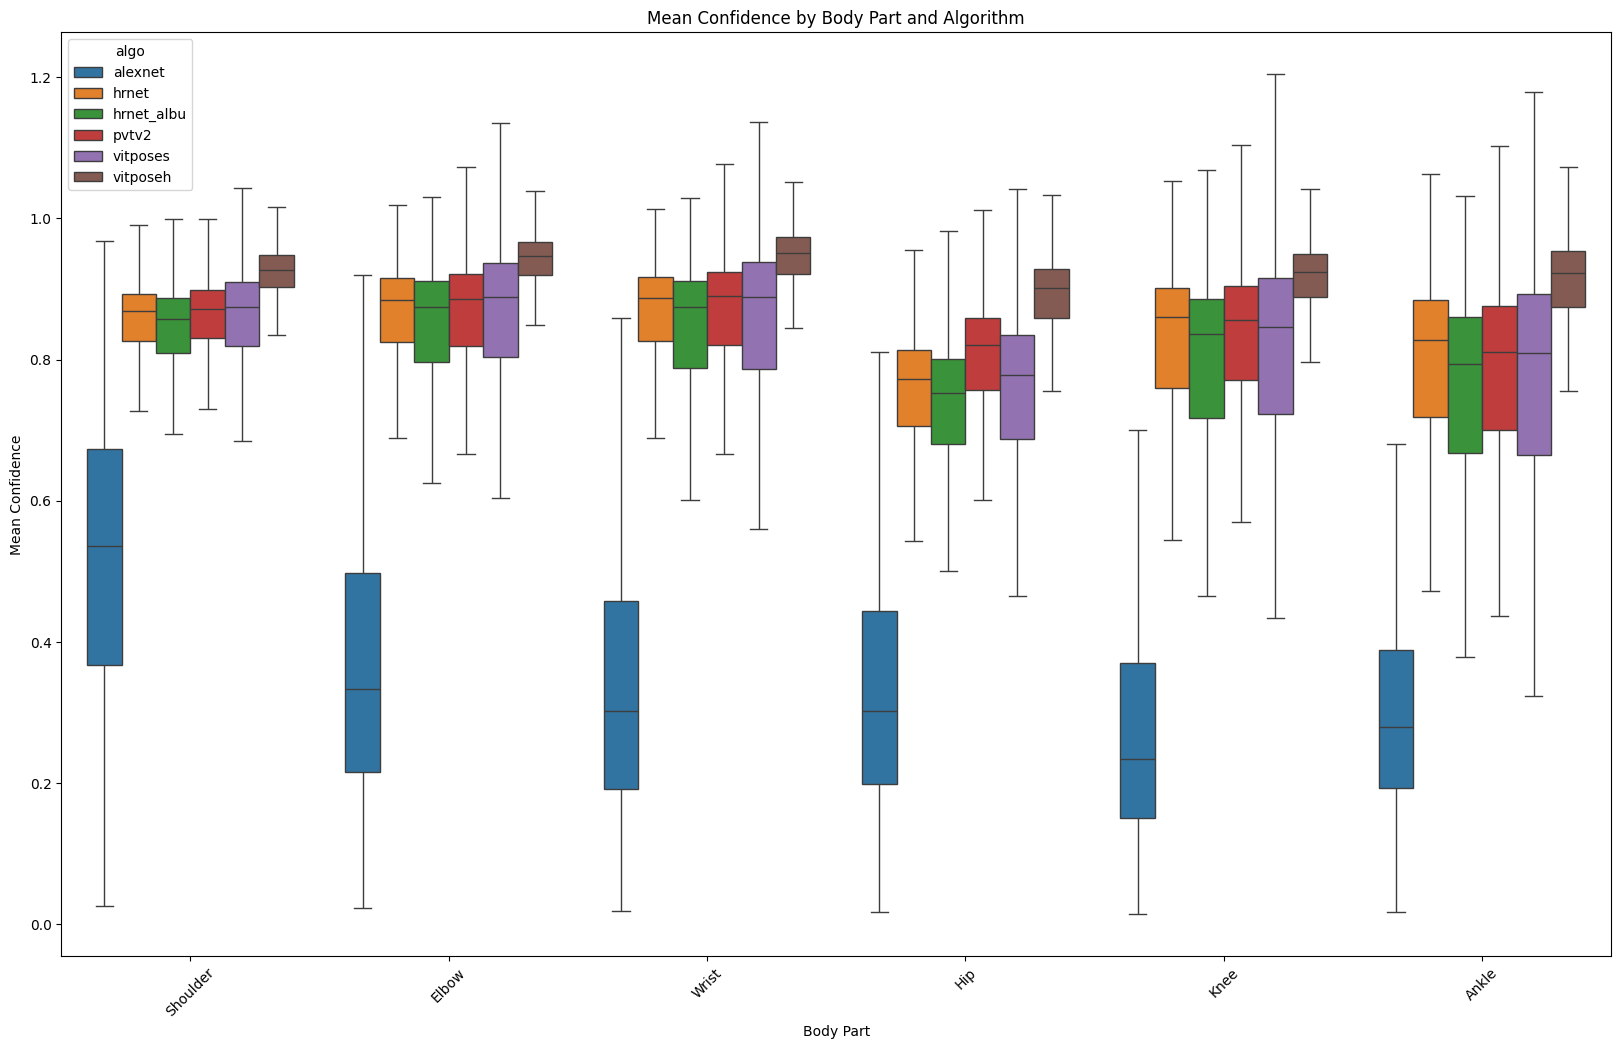

In [122]:
# plot averaging across L/R sides, and filtering by key body parts:

plt.figure(figsize=(20, 12))

sns.boxplot(x='part', y='c', hue='algo', data=test, showfliers=False)
plt.title('Mean Confidence by Body Part and Algorithm')
plt.ylabel('Mean Confidence')
plt.xlabel('Body Part')
plt.xticks(rotation=45)
plt.show()

In [123]:
df = compare_df[(compare_df.algo == algo) & (compare_df.c > 0.7)]
keypoints_per_frame = df.groupby('frame')['bp'].nunique()

keypoints_per_frame

frame
0       18
1       18
2       18
3       18
4       18
        ..
5326    18
5327    18
5328    18
5329    18
5330    18
Name: bp, Length: 5331, dtype: int64

In [66]:
# compare the number of frames with all keypoints above a specific threshold for thresholds from 0 to 1

thresholds = np.linspace(0, 1, 100)
data = []

for threshold in thresholds:
    for algo in all_algos:
        # Filter for current algorithm and confidence > threshold
        df = compare_df[(compare_df.algo == algo) & (compare_df.c > threshold)]

        # Count unique keypoints per frame
        keypoints_per_frame = df.groupby('frame')['bp'].nunique()

        # Keep only frames with all 17 keypoints
        good_frames = keypoints_per_frame[keypoints_per_frame == 18]

        data.append({
            'threshold': threshold,
            'algo': algo,
            'num_frames': len(good_frames)
        })

# Convert to DataFrame
df_plot = pd.DataFrame(data)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x='threshold', y='num_frames', hue='algo')
plt.title('Frames with All 17 Keypoints Above Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Number of Valid Frames')
plt.tight_layout()
# plt.savefig('frames_with_all_keypoints_above_threshold.png')
plt.show()



KeyboardInterrupt: 

In [ ]:
results = []

# Loop over each unique combination
for algo in test['algo'].unique():
    algo_df = test[test['algo'] == algo]
    
    for video in algo_df['video'].unique():
        video_df = algo_df[algo_df['video'] == video]
        
        for bp in video_df['bp'].unique():
            kp_df = video_df[video_df['bp'] == bp].copy()
            
            # Drop NaNs and sort by frame
            kp_df = kp_df.dropna(subset=['x', 'y', 'frame']).sort_values('frame')
            
            if kp_df.shape[0] < 4:
                jerk_rms = np.nan
            else:
                # Displacement
                

                dx = kp_df['x'].diff()
                dy = kp_df['y'].diff()
                displacement = np.sqrt(dx**2 + dy**2)

                # Jerk = 3rd derivative of displacement
                jerk = np.diff(displacement, n=3)
                

                if len(jerk) == 0:
                    jerk_rms = np.nan
                else:
                    #  drop NaNs and compute RMS
                    jerk = jerk[~np.isnan(jerk)]
                    jerk_rms = np.sqrt(np.mean(jerk**2))
                    # print('computing jerk for', algo, video, bp, jerk_rms)
            # Save result
            results.append({
                'algo': algo,
                'video': video,
                'bp': bp,
                'jerk_rms': jerk_rms,
                'side': kp_df['side'].iloc[0],
                'part': kp_df['part'].iloc[0]
            })

# Convert to DataFrame
jerk_rms_df = pd.DataFrame(results)

jerk_rms_df.head()

computing jerk for alexnet video_000269 RShoulder 10.929927929194111
computing jerk for alexnet video_000269 RElbow 21.770771172123325
computing jerk for alexnet video_000269 RWrist 156.0712102733229
computing jerk for alexnet video_000269 LShoulder 12.66944868115647
computing jerk for alexnet video_000269 LElbow 35.037932066414875
computing jerk for alexnet video_000269 LWrist 157.68041085074722
computing jerk for alexnet video_000269 RHip 68.81901120270464
computing jerk for alexnet video_000269 RKnee 135.1930187504577
computing jerk for alexnet video_000269 RAnkle 49.772202308648275
computing jerk for alexnet video_000269 LHip 49.35628458976829
computing jerk for alexnet video_000269 LKnee 120.0772126418997
computing jerk for alexnet video_000269 LAnkle 37.228200465986596
computing jerk for alexnet video_000059 RShoulder 166.14825195163684
computing jerk for alexnet video_000059 RElbow 379.72293946445143
computing jerk for alexnet video_000059 RWrist 714.1234511758856
computing jerk

,algo,video,bp,jerk_rms,side,part
0,alexnet,video_000269,RShoulder,10.929928,R,Shoulder
1,alexnet,video_000269,RElbow,21.770771,R,Elbow
2,alexnet,video_000269,RWrist,156.071210,R,Wrist
3,alexnet,video_000269,LShoulder,12.669449,L,Shoulder
4,alexnet,video_000269,LElbow,35.037932,L,Elbow


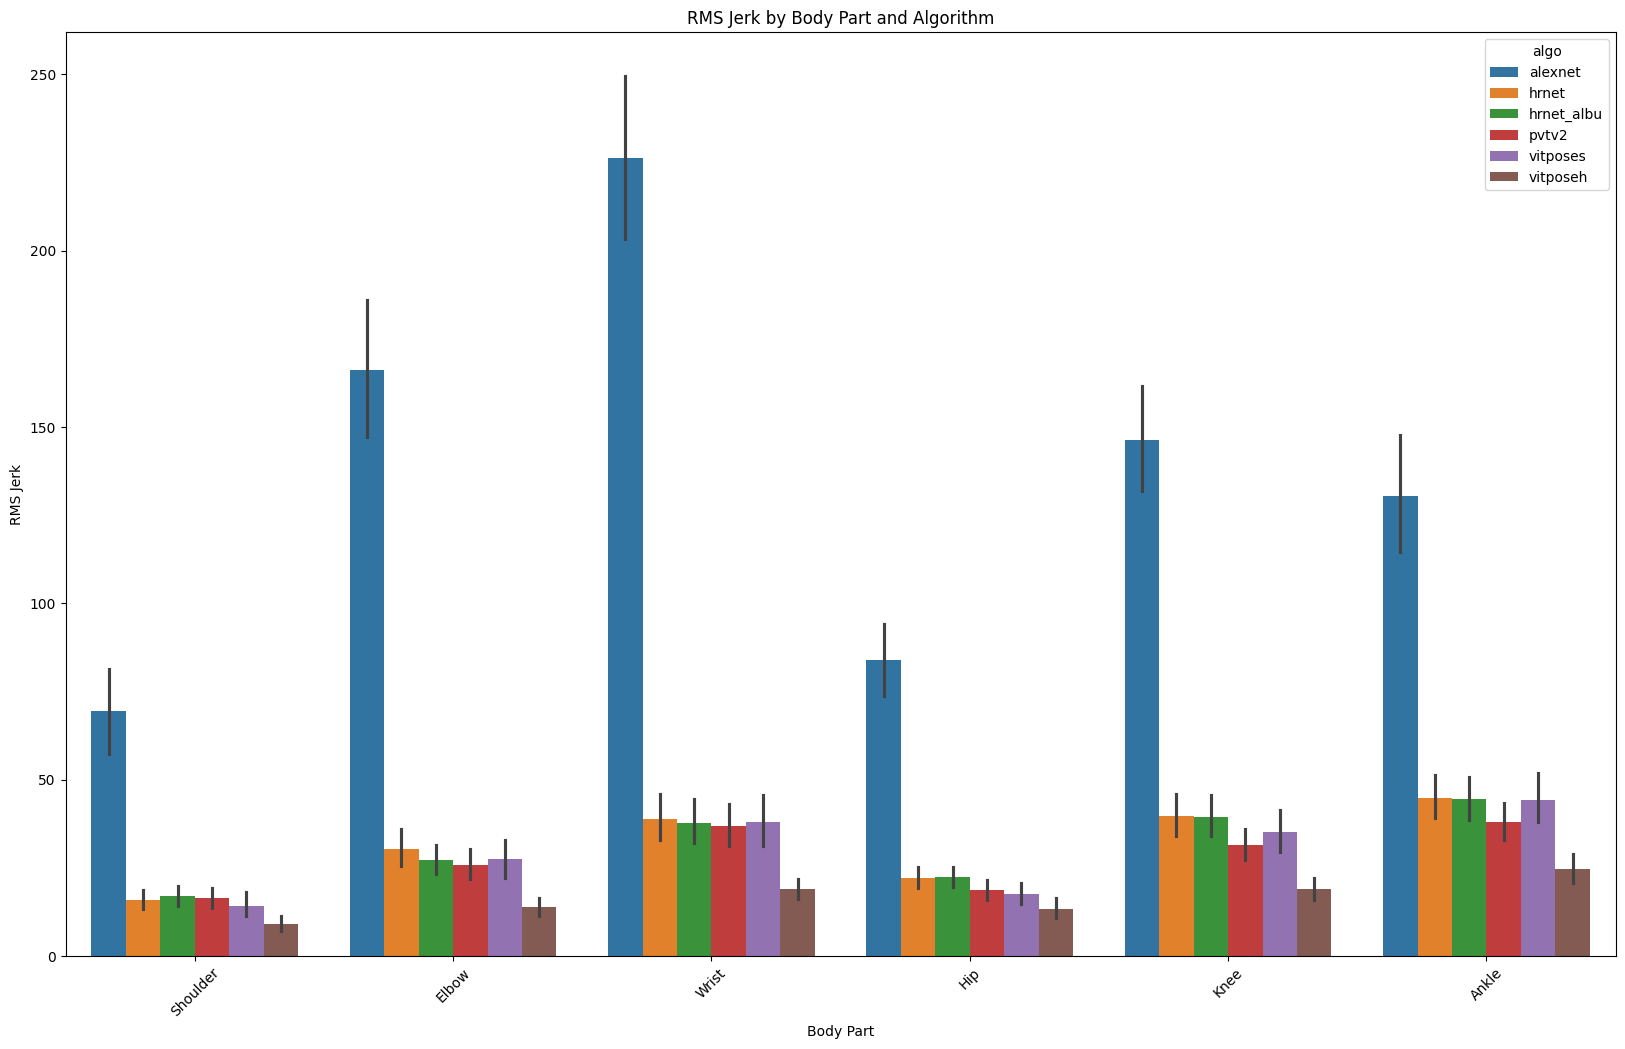

In [163]:
# plot with seaborn 
plt.figure(figsize=(20, 12))

#sns.boxplot(x='bp', y='jerk_rms', hue='algo', data=jerk_rms_df, showfliers=False)
sns.barplot(x='part', y='jerk_rms', hue='algo', data=jerk_rms_df)
plt.title('RMS Jerk by Body Part and Algorithm')
plt.ylabel('RMS Jerk')
plt.xlabel('Body Part')
plt.xticks(rotation=45)

plt.savefig('jerk_rms.png')
plt.show()

In [6]:
mean_confidence_by_algo

,bp,algo,c
0,LAnkle,alexnet,0.303862
1,LAnkle,hrnet,0.773570
2,LAnkle,hrnet_albu,0.741740
3,LAnkle,pvtv2,0.768382
4,LAnkle,vitposeh,0.885880
...,...,...,...
103,RWrist,hrnet,0.830903
104,RWrist,hrnet_albu,0.812566
105,RWrist,pvtv2,0.835841
106,RWrist,vitposeh,0.912834


In [ ]:
# make a table summarizing the results for both jerk, mean confidence, and number of frames with all keypoints above a threshold 

jerk_summary = jerk_rms_df.groupby(['algo', 'part'])['jerk_rms'].mean().reset_index()
confidence_summary = mean_confidence_by_algo.groupby(['algo', 'bp'])['c'].mean().reset_index()
frames_summary = df_plot.groupby(['algo'])['num_frames'].max().reset_index()


KeyError: 'part'

In [ ]:

summary = jerk_summary.merge(confidence_summary, on=['algo', 'part'], how='outer')
summary = summary.merge(frames_summary, on='algo', how='outer')

summary.head()



In [22]:
test

,video,algo,bp,frame,x,y,c,fps,pixel_x,pixel_y,...,lrefx,refx,refy,ref_dist,ref_angle,x_rotate,y_rotate,delta_t,side,part
2,video_000269,alexnet,RShoulder,0,90.626968,160.619049,0.566304,28.621,272,480,...,133.731689,139.119774,163.184807,174.554667,6.230325,-0.278197,0.000000,0.034939,R,Shoulder
3,video_000269,alexnet,RElbow,0,47.522243,247.854797,0.485013,28.621,272,480,...,133.731689,139.119774,163.184807,174.554667,6.230325,-0.498388,0.512111,0.034939,R,Elbow
4,video_000269,alexnet,RWrist,0,9.805616,314.564453,0.330546,28.621,272,480,...,133.731689,139.119774,163.184807,174.554667,6.230325,-0.693967,0.905164,0.034939,R,Wrist
5,video_000269,alexnet,LShoulder,0,187.612579,165.750565,0.392626,28.621,272,480,...,133.731689,139.119774,163.184807,174.554667,6.230325,0.278197,0.000000,0.034939,L,Shoulder
6,video_000269,alexnet,LElbow,0,263.045837,222.197220,0.561211,28.621,272,480,...,133.731689,139.119774,163.184807,174.554667,6.230325,0.726826,0.300091,0.034939,L,Elbow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11396043,video_000077,vitposeh,RKnee,209,356.689312,524.933715,0.895769,29.970,1280,720,...,518.969572,518.969572,597.582246,230.076782,5.825321,-0.772256,0.028546,0.033367,R,Knee
11396044,video_000077,vitposeh,RAnkle,209,379.886382,666.803588,0.898579,29.970,1280,720,...,518.969572,518.969572,597.582246,230.076782,5.825321,-0.409252,0.537085,0.033367,R,Ankle
11396045,video_000077,vitposeh,LHip,209,575.602149,625.490313,0.815136,29.970,1280,720,...,518.969572,518.969572,597.582246,230.076782,5.825321,0.274411,0.000000,0.033367,L,Hip
11396046,video_000077,vitposeh,LKnee,209,651.519940,667.287306,0.871074,29.970,1280,720,...,518.969572,518.969572,597.582246,230.076782,5.825321,0.650693,0.017097,0.033367,L,Knee


In [33]:
results = []

for l1, l2 in limbs_by_name.values():
    limb_name = [k for k, v in limbs_by_name.items() if v == [l1, l2]][0]

    # Filter data for the keypoints
    l1_data = test[test['bp'] == l1].sort_values(by='frame')
    l2_data = test[test['bp'] == l2].sort_values(by='frame')

    # Ensure alignment by frame
    merged = pd.merge(l1_data, l2_data, on=['video', 'frame', 'algo'], suffixes=('_1', '_2'))

    # Compute limb length
    merged['length'] = np.sqrt((merged['x_1'] - merged['x_2'])**2 + (merged['y_1'] - merged['y_2'])**2)
    merged['limb'] = limb_name

    # Select desired columns
    results.append(merged[['video', 'algo', 'limb', 'frame', 'length']])

# Concatenate all results
limb_df = pd.concat(results, ignore_index=True)

limb_df.head()

,video,algo,limb,frame,length
0,video_000269,alexnet,Shoulder Width,0,97.121271
1,video_000347,vitposes,Shoulder Width,0,77.536146
2,video_000365,vitposes,Shoulder Width,0,228.659900
3,video_000346,vitposes,Shoulder Width,0,80.459900
4,video_000072,vitposes,Shoulder Width,0,104.658211


video         frame
video_000000  0        6
              1        6
              2        6
              3        6
              4        6
                      ..
video_000412  1254     6
              1255     6
              1256     6
              1257     6
              1258     6
Name: algo, Length: 105519, dtype: int64

In [72]:
# get the mean limb length for each limb for each video and algorithm
limb_summary = limb_df.groupby(['video', 'algo', 'limb'])['length'].mean().reset_index()
limb_summary['standard_deviation'] = limb_df.groupby(['video', 'algo', 'limb'])['length'].std().reset_index()['length']

limb_summary['side'] = limb_summary['limb'].apply(lambda x: 'L' if x[0] == 'L' else ('R' if x[0] == 'R' else 'N'))
limb_summary['part'] = limb_summary['limb'].apply(lambda x: x[1:] if x[0] == 'L' or x[0] == 'R' else x) 


limb_summary.head()

,video,algo,limb,length,standard_deviation,side,part
0,video_000000,alexnet,Hip Width,87.672498,48.339650,N,Hip Width
1,video_000000,alexnet,L calf,185.897020,67.813039,L,calf
2,video_000000,alexnet,L lower arm,176.650153,117.145261,L,lower arm
3,video_000000,alexnet,L thigh,163.634153,58.785652,L,thigh
4,video_000000,alexnet,L torso,199.139792,57.488430,L,torso


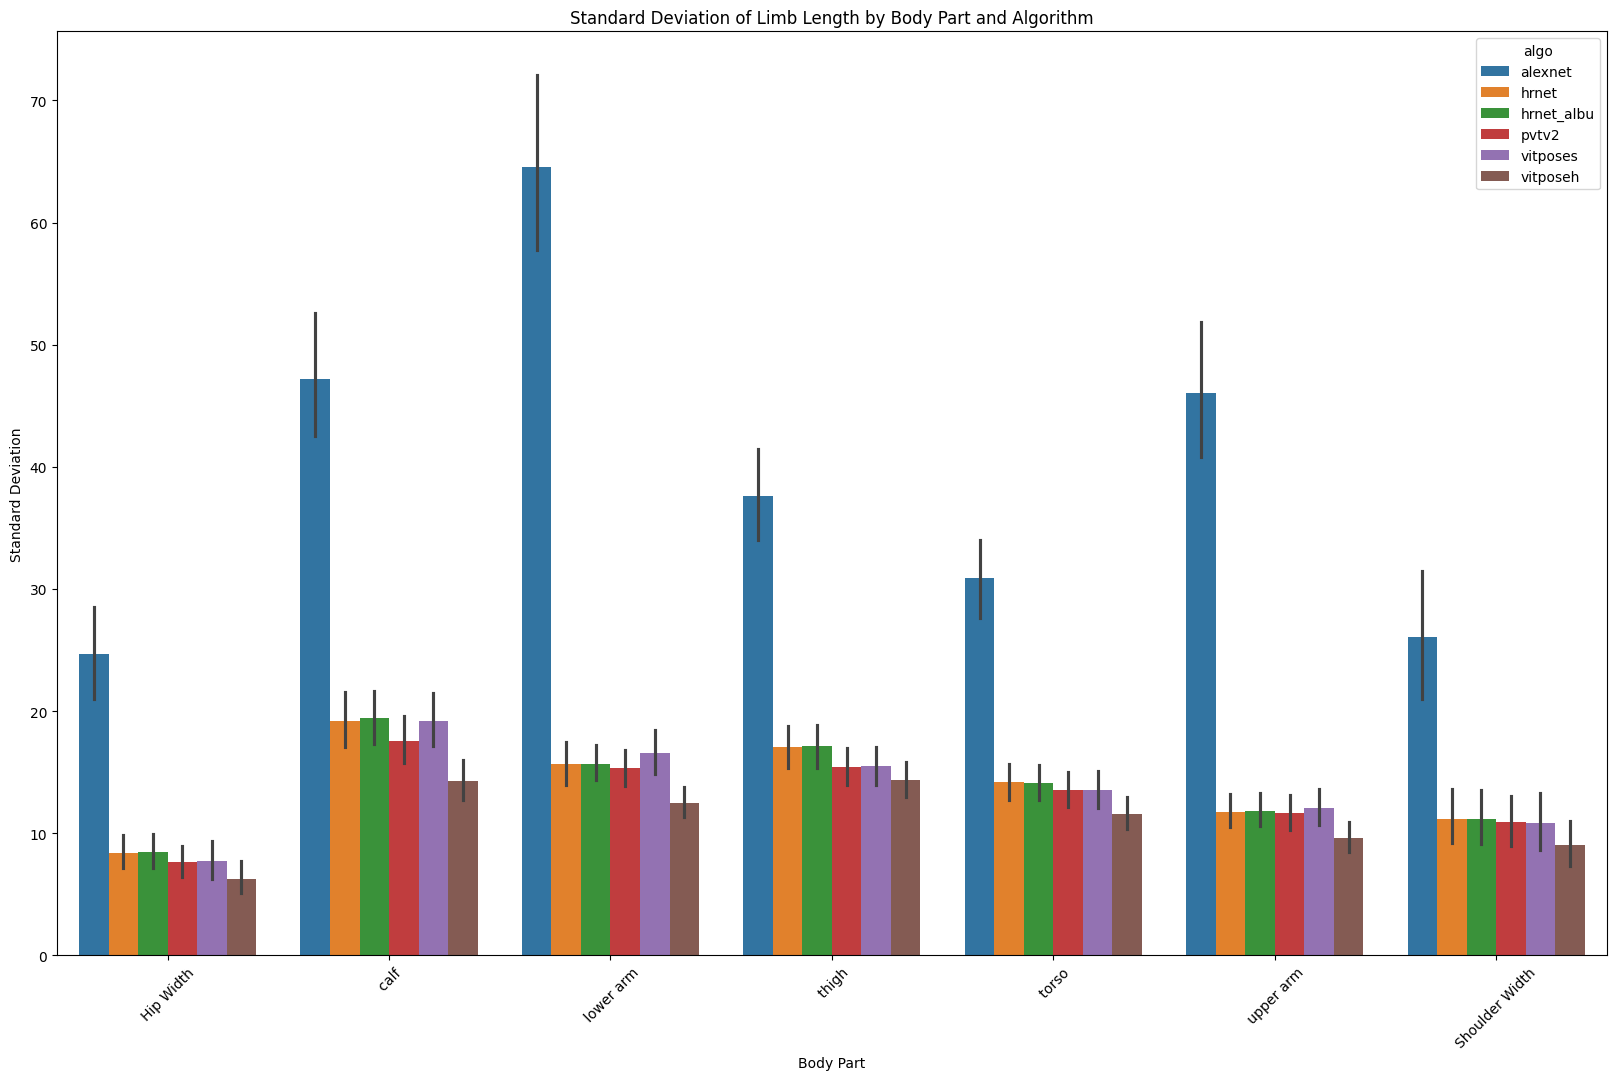

In [75]:
#plot the standard deviation of limb lengths by body part and algorithm
plt.figure(figsize=(20, 12))
algorithm_order = ['alexnet', 'hrnet', 'hrnet_albu', 'pvtv2', 'vitposes', 'vitposeh']

sns.barplot(x='part', y='standard_deviation', hue='algo', data=limb_summary, hue_order=algorithm_order)
plt.title('Standard Deviation of Limb Length by Body Part and Algorithm')
plt.ylabel('Standard Deviation')
plt.xlabel('Body Part')
plt.xticks(rotation=45)
plt.savefig('limb_length_std.png')
plt.show()

In [125]:
import scipy.stats as stats
import scikit_posthocs as sp
import statsmodels

summary_stats = limb_summary.groupby(['part', 'algo']).agg(
    mean_std=('standard_deviation', 'mean'),
    std_std=('standard_deviation', 'std'),
    count=('standard_deviation', 'count')
).reset_index()


# Conduct Kruskal-Wallis test by part
kw_results = limb_summary.groupby('part').apply(
    lambda group: stats.kruskal(*[group[group['algo'] == algo]['standard_deviation'] for algo in group['algo'].unique()])
)

# Extract p-values
kw_results = kw_results.apply(lambda x: x.pvalue)

posthoc_results = limb_summary.groupby('part').apply(
    lambda group: sp.posthoc_dunn(group, val_col='standard_deviation', group_col='algo')
)

posthoc_adjusted = posthoc_results.apply(lambda table: table.apply(lambda x: statsmodels.stats.multitest.multipletests(x, method='bonferroni')[1]))

stats_result = pd.DataFrame(posthoc_adjusted['vitposeh']).reset_index()

stats_result.rename(columns={'level_1': 'algo', 'vitposeh': 'p-value'}, inplace=True)
stats_result['p-value'] = [p[0] for p in stats_result['p-value']]
stats_result = stats_result[stats_result['p-value'] < 0.05]
stats_result = stats_result[stats_result['algo'] != 'vitposeh']
stats_result = stats_result.pivot(index='part', columns='algo', values='p-value')
formatted_df = stats_result.applymap(lambda x: f'{x:.2e}' if pd.notna(x) else '-')

print(formatted_df)

algo             alexnet     hrnet hrnet_albu     pvtv2  vitposes
part                                                             
 calf           1.89e-50  1.03e-04   5.21e-05  4.04e-03  1.85e-04
 lower arm      1.98e-58  2.77e-03   7.37e-04  3.32e-03  1.93e-03
 thigh          1.13e-35  1.41e-02   2.06e-02         -         -
 torso          7.63e-33  7.06e-04   1.53e-03  3.21e-03  7.09e-03
 upper arm      1.27e-48  9.65e-03   6.47e-03  1.28e-02  2.11e-02
Hip Width       4.14e-25  8.59e-04   3.24e-04  1.07e-02         -
Shoulder Width  2.83e-14  4.73e-02   4.16e-02  4.94e-02         -
